The objective of this project is to demonstrate that a dynamic volatility model (GARCH) provides more effective hedging performance than a simple static volatility model (Historical Volatility). The Black-Scholes (BS) Model assumes volatility is constant. This is its biggest weakness. In the real world scenario, volatility is not constant. In some cass, it exhibits "clustering" periods of high volatility, followed by more high volatility, and low by low.

The GARCH model is designed to capture volatility clustering. The variance of the error term in GARCH models is assumed to vary systematically, conditional on the average size of the error terms in previous periods. In other words, it has conditional heteroskedasticity, and the reason for the heteroskedasticity is that the error term is following an autoregressive moving average pattern. This means that it is a function of an average of its own past values.

In this project, we will implement a rolling forecast scheme for GARCH(1,1) model, use it to price and hedge options daily, and then compare its performance against a simpler "historical volatility" (HV) model. But the GARCH(1,1) is a symmetric model. It treats a +5% shock and a -5% shock as having the exact same impact on future volatility. 30-Day HV is implicitly asymmetric. A big price drop will increase the std() of the last 30 days, raising the volatility. While it's a "dumb" model, it's at least reacting to the event. Thus we also use a more sophisticated, an Asymmetric GARCH Model i.e. the GJR-GARCH model (Glosten-Jagannathan-Runkle GARCH). This model is identical to GARCH(1,1) but adds one new parameter ($\gamma$, or "gamma") that specifically measures the impact of negative news. If $\gamma > 0$, it means negative shocks (price drops) have a stronger impact on volatility than positive shocks, which is exactly what the leverage effect describes. Thus in this project we run a comparison between three models:
- Benchmark: 30-Day Historical Vol (HV)
- Symmetric Model: GARCH(1,1)
- Asymmetric Model: GJR-GARCH(1,1)

 This implementation runs the simulation for five tickers (AAPL, GOOGL, MSFT, NVDA, TSLA) and compares the hedging performances for the three models listed above.

#### Cell 1: Imports

In [16]:
!pip install arch

import yfinance as yf
import numpy as np
import pandas as pd
from arch import arch_model
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta

# Suppress convergence warnings from the GARCH model
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

#### Cell 2: Global Settings & Data Download

In [17]:
# --- Settings ---
TICKERS = ['AAPL', 'GOOGL', 'MSFT', 'NVDA', 'TSLA']
START_DATE = '2015-01-01'
END_DATE = '2024-12-31'
ROLLING_WINDOW_DAYS = 500 # Use ~2 years of data for GARCH fit
BACKTEST_START_DATE = '2017-01-01' # Start backtest later
OPTION_MATURITY_DAYS = 30 # We will simulate 30-day options

# --- Download Data ---
print("Downloading price data...")
# Download stock data
data = yf.download(TICKERS, start=START_DATE, end=END_DATE)

# Access 'Adj Close' correctly from the MultiIndex columns
prices = data['Close'].dropna()
returns = np.log(prices / prices.shift(1)).dropna() * 100 # GARCH model works better with returns in %

# Download risk-free rate proxy (13-week T-Bill)
rf_data = yf.download('^IRX', start=START_DATE, end=END_DATE)
rf_data = rf_data['Close', '^IRX']
rf_data = rf_data.ffill().dropna() / 100 # Convert from % to decimal

# Align data
prices, returns = prices.align(returns, join='inner', axis=0)
rf_data = rf_data.reindex(prices.index).ffill() # Reindex rf_data with prices index and forward fill

print("Data download complete.")
print(f"GARCH Rolling Window Size: {ROLLING_WINDOW_DAYS} days")
print(f"Backtest period: {BACKTEST_START_DATE} to {END_DATE}")

[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed

Data download complete.
GARCH Rolling Window Size: 500 days
Backtest period: 2017-01-01 to 2024-12-31


#### Cell 3: Black-Scholes Helper Functions

These are the standard formulas needed to price options and calculate delta.

In [18]:
def d1(S, K, T, r, sigma):
    """Calculates d1 for Black-Scholes"""
    if T == 0: T = 0.0001 # Avoid division by zero
    return (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

def d2(S, K, T, r, sigma):
    """Calculates d2 for Black-Scholes"""
    return d1(S, K, T, r, sigma) - sigma * np.sqrt(T)

def bs_call_price(S, K, T, r, sigma):
    """Calculates Black-Scholes call option price"""
    if sigma == 0: return max(0, S - K) # Payoff at 0 vol
    if T == 0: return max(0, S - K) # Payoff at expiry
    return (S * norm.cdf(d1(S, K, T, r, sigma)) - K * np.exp(-r * T) * norm.cdf(d2(S, K, T, r, sigma)))

def bs_call_delta(S, K, T, r, sigma):
    """Calculates Black-Scholes call option delta"""
    if T == 0: return 1.0 if S > K else 0.0 # Delta at expiry
    return norm.cdf(d1(S, K, T, r, sigma))

#### Cell 4: The Backtest Simulation Function

This is the core of the project. It simulates the daily process of selling and hedging options.

In [19]:
def run_hedging_backtest_rolling(ticker, prices_all, returns_all, rf_all, window_size):
    """
    Runs the full rolling delta-hedging simulation using a
    ROLLING GARCH and GJR-GARCH model.
    """
    print(f"Starting ROLLING backtest for {ticker} (This may take a few minutes)...")

    # Get the data for the backtest period
    prices = prices_all.loc[BACKTEST_START_DATE:]
    rf = rf_all.loc[BACKTEST_START_DATE:]

    # Store final P&L for each expired option
    final_pnls = {'HV': [], 'GARCH': [], 'GJR': []}

    # Dictionary to track all our active options and their hedge portfolios
    active_portfolios = {}

    # --- Start Daily Simulation Loop ---
    for i in range(len(prices)):
        today = prices.index[i]
        S_t = prices.iloc[i]
        r_t = rf.iloc[i]

        # 1. Get all returns *before* today
        all_past_returns = returns_all[ticker].loc[:today].iloc[:-1]

        if len(all_past_returns) < window_size:
            continue

        # 2. Define training sets
        hv_train_data = all_past_returns.iloc[-30:] # Last 30 days for HV
        garch_train_data = all_past_returns.iloc[-window_size:] # Last N days for GARCH

        # 3. Update Volatility Forecasts

        # Model A: 30-Day Rolling Historical Volatility
        hv_forecast = hv_train_data.std() * np.sqrt(252) / 100

        # Model B & C: GARCH(1,1) and GJR-GARCH(1,1,1)
        try:
            # Fit GARCH(1,1) (p=1, q=1)
            model_garch = arch_model(garch_train_data, vol='Garch', p=1, q=1)
            fit_garch = model_garch.fit(disp='off', update_freq=0)
            forecast_garch = fit_garch.forecast(horizon=1)
            var_garch = forecast_garch.variance.iloc[-1].values[0]
            garch_forecast = np.sqrt(var_garch * 252) / 100

            # Fit GJR-GARCH (p=1, o=1, q=1) - 'o=1' adds the asymmetric term
            model_gjr = arch_model(garch_train_data, vol='Garch', p=1, o=1, q=1)
            fit_gjr = model_gjr.fit(disp='off', update_freq=0)
            forecast_gjr = fit_gjr.forecast(horizon=1)
            var_gjr = forecast_gjr.variance.iloc[-1].values[0]
            gjr_forecast = np.sqrt(var_gjr * 252) / 100

        except Exception as e:
            # Fallback if models fail
            garch_forecast = hv_forecast
            gjr_forecast = hv_forecast

        # ---
        # 2. Manage Active Portfolios (Re-hedging & Expiry)
        # ---

        for expiry_date in list(active_portfolios.keys()):
            port = active_portfolios[expiry_date]

            if expiry_date <= today:
                payoff = max(0, S_t - port['K'])

                final_pnls['HV'].append(port['hv_cash'] - payoff + port['hv_shares'] * S_t)
                final_pnls['GARCH'].append(port['garch_cash'] - payoff + port['garch_shares'] * S_t)
                final_pnls['GJR'].append(port['gjr_cash'] - payoff + port['gjr_shares'] * S_t)

                del active_portfolios[expiry_date]

            else:
                T_rem = (expiry_date - today).days / 365.25

                # --- Re-hedge HV ---
                new_hv_delta = bs_call_delta(S_t, port['K'], T_rem, r_t, hv_forecast)
                port['hv_cash'] -= (new_hv_delta - port['hv_shares']) * S_t
                port['hv_shares'] = new_hv_delta

                # --- Re-hedge GARCH ---
                new_garch_delta = bs_call_delta(S_t, port['K'], T_rem, r_t, garch_forecast)
                port['garch_cash'] -= (new_garch_delta - port['garch_shares']) * S_t
                port['garch_shares'] = new_garch_delta

                # --- Re-hedge GJR ---
                new_gjr_delta = bs_call_delta(S_t, port['K'], T_rem, r_t, gjr_forecast)
                port['gjr_cash'] -= (new_gjr_delta - port['gjr_shares']) * S_t
                port['gjr_shares'] = new_gjr_delta

        # ---
        # 3. "Sell" a New 30-Day Option
        # ---

        if (prices.index[-1] - today).days >= OPTION_MATURITY_DAYS:
            expiry_date = today + pd.Timedelta(days=OPTION_MATURITY_DAYS)
            K_atm = S_t
            T_opt = (OPTION_MATURITY_DAYS / 365.25)

            # Get prices and deltas for all 3 models
            hv_price = bs_call_price(S_t, K_atm, T_opt, r_t, hv_forecast)
            hv_delta = bs_call_delta(S_t, K_atm, T_opt, r_t, hv_forecast)

            garch_price = bs_call_price(S_t, K_atm, T_opt, r_t, garch_forecast)
            garch_delta = bs_call_delta(S_t, K_atm, T_opt, r_t, garch_forecast)

            gjr_price = bs_call_price(S_t, K_atm, T_opt, r_t, gjr_forecast)
            gjr_delta = bs_call_delta(S_t, K_atm, T_opt, r_t, gjr_forecast)

            # Create new portfolio
            active_portfolios[expiry_date] = {
                'K': K_atm,
                'hv_cash': hv_price - (hv_delta * S_t),
                'hv_shares': hv_delta,
                'garch_cash': garch_price - (garch_delta * S_t),
                'garch_shares': garch_delta,
                'gjr_cash': gjr_price - (gjr_delta * S_t),
                'gjr_shares': gjr_delta
            }

    print(f"ROLLING backtest for {ticker} complete.")
    return pd.DataFrame(final_pnls)

#### Cell 5: Run Simulations

This cell executes the backtest function for each of our tickers.

In [20]:
all_results = {}

for ticker in TICKERS:
    result_df = run_hedging_backtest_rolling(
        ticker,
        prices[ticker],
        returns, # Pass the entire returns DataFrame
        rf_data,
        window_size=ROLLING_WINDOW_DAYS # Pass the window size
    )
    all_results[ticker] = result_df

print("\nAll rolling simulations complete!")

Starting ROLLING backtest for AAPL (This may take a few minutes)...
ROLLING backtest for AAPL complete.
Starting ROLLING backtest for GOOGL (This may take a few minutes)...
ROLLING backtest for GOOGL complete.
Starting ROLLING backtest for MSFT (This may take a few minutes)...
ROLLING backtest for MSFT complete.
Starting ROLLING backtest for NVDA (This may take a few minutes)...
ROLLING backtest for NVDA complete.
Starting ROLLING backtest for TSLA (This may take a few minutes)...


/tmp/ipython-input-2153590323.py:50: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  fit_gjr = model_gjr.fit(disp='off', update_freq=0)
/tmp/ipython-input-2153590323.py:50: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  fit_gjr = model_gjr.fit(disp='off', update_freq=0)


ROLLING backtest for TSLA complete.

All rolling simulations complete!


#### Cell 6: Analysis & Visualization

This cell prints the statistics and plots the results.


--- Final Hedging Performance Analysis (Rolling GARCH vs GJR) ---

         Results for AAPL
       Mean Hedging P&L  Std Dev of P&L (Risk)  Variance of P&L
HV             0.109451               1.410681         1.990020
GARCH          0.217205               1.439042         2.070841
GJR            0.213699               1.497258         2.241783

AAPL GARCH(1,1) Variance Reduction vs HV: -4.06%
AAPL GJR-GARCH Variance Reduction vs HV: -12.65%


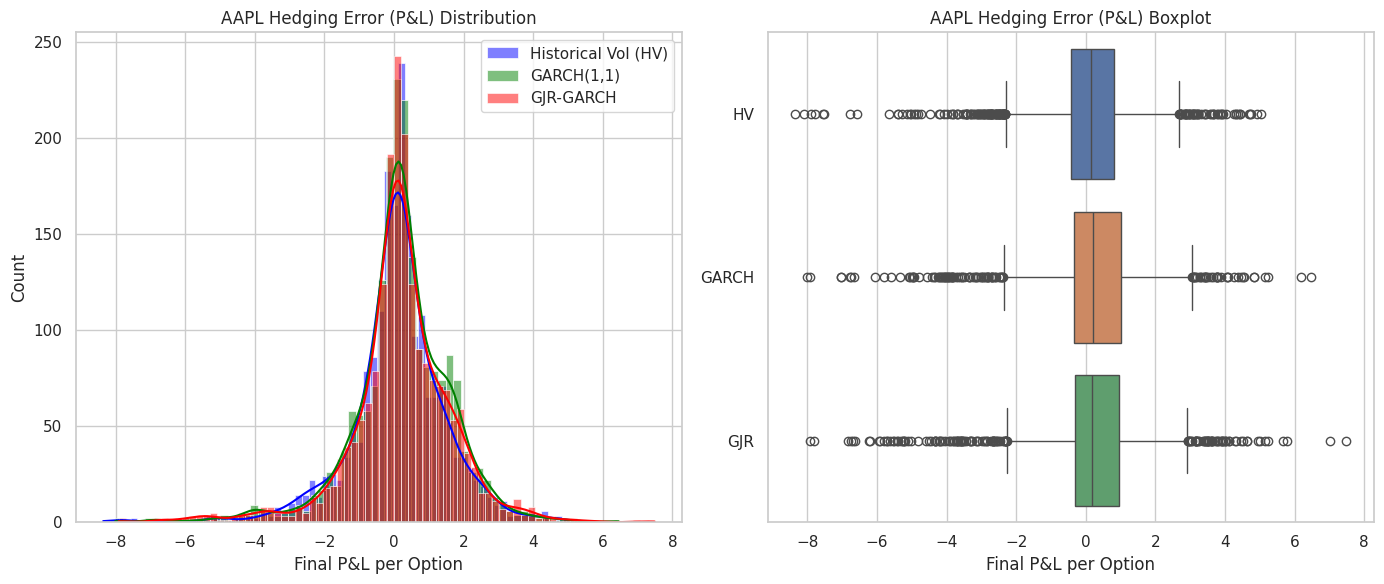


         Results for GOOGL
       Mean Hedging P&L  Std Dev of P&L (Risk)  Variance of P&L
HV             0.073515               1.407085         1.979888
GARCH          0.171883               1.271807         1.617494
GJR            0.157346               1.258110         1.582840

GOOGL GARCH(1,1) Variance Reduction vs HV: 18.30%
GOOGL GJR-GARCH Variance Reduction vs HV: 20.05%


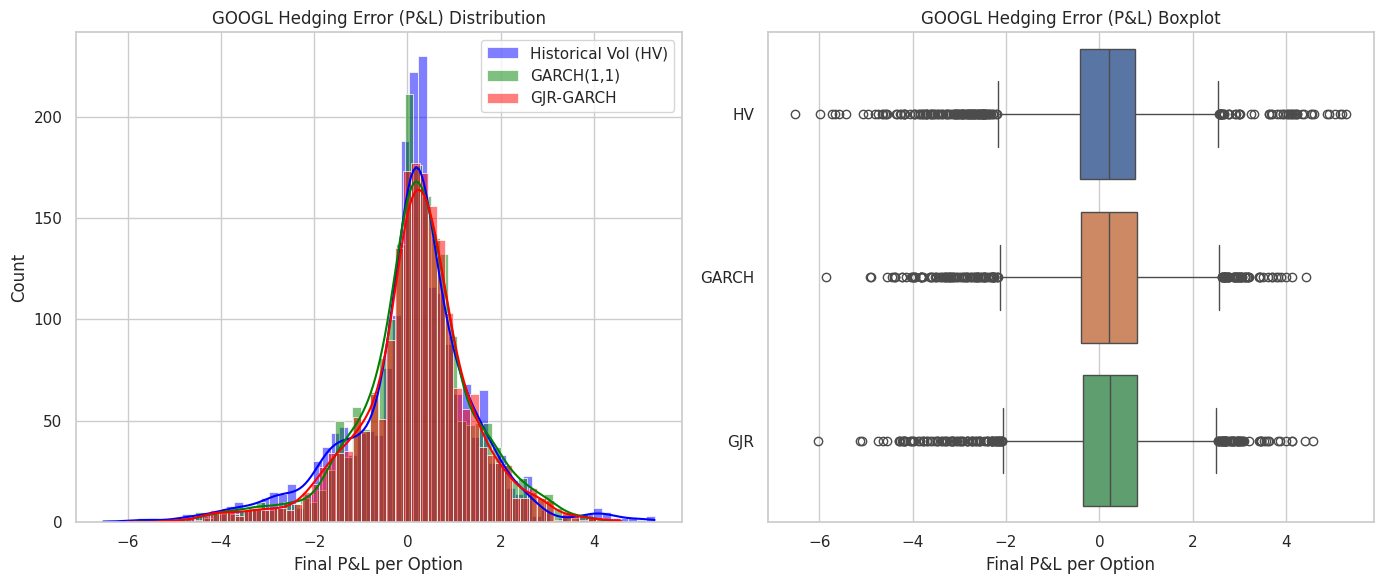


         Results for MSFT
       Mean Hedging P&L  Std Dev of P&L (Risk)  Variance of P&L
HV             0.153170               2.904172         8.434218
GARCH          0.256903               2.684961         7.209014
GJR            0.141851               2.622049         6.875142

MSFT GARCH(1,1) Variance Reduction vs HV: 14.53%
MSFT GJR-GARCH Variance Reduction vs HV: 18.49%


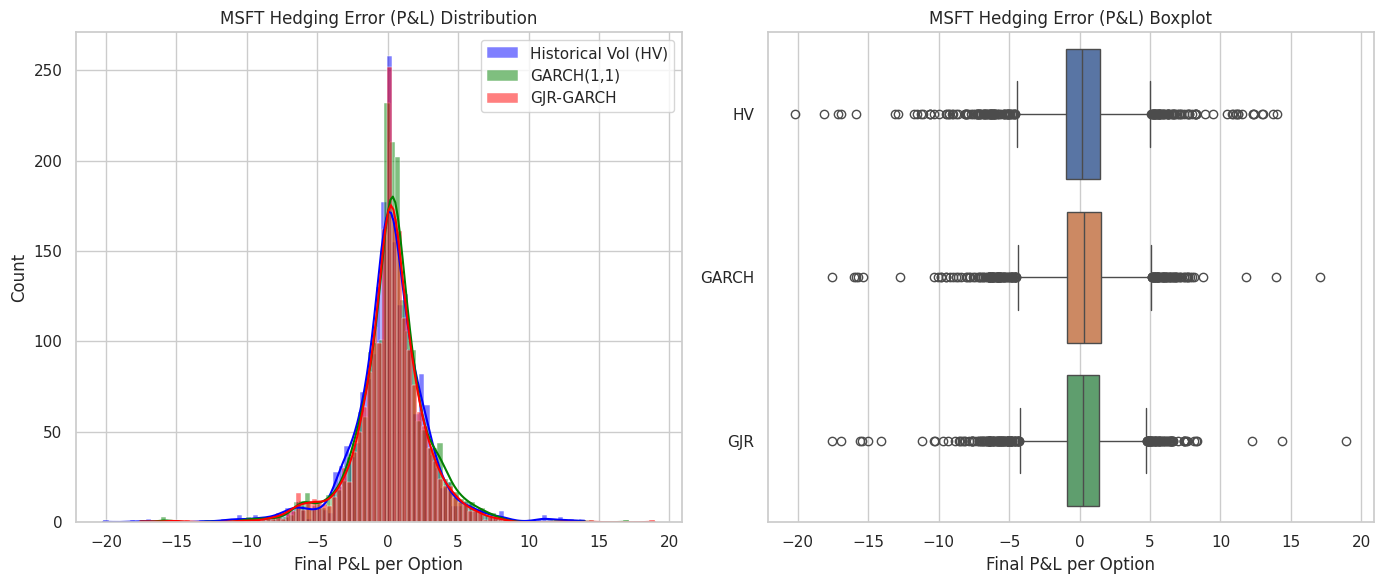


         Results for NVDA
       Mean Hedging P&L  Std Dev of P&L (Risk)  Variance of P&L
HV             0.049917               0.829982         0.688869
GARCH          0.054675               0.776483         0.602926
GJR            0.088980               0.799513         0.639222

NVDA GARCH(1,1) Variance Reduction vs HV: 12.48%
NVDA GJR-GARCH Variance Reduction vs HV: 7.21%


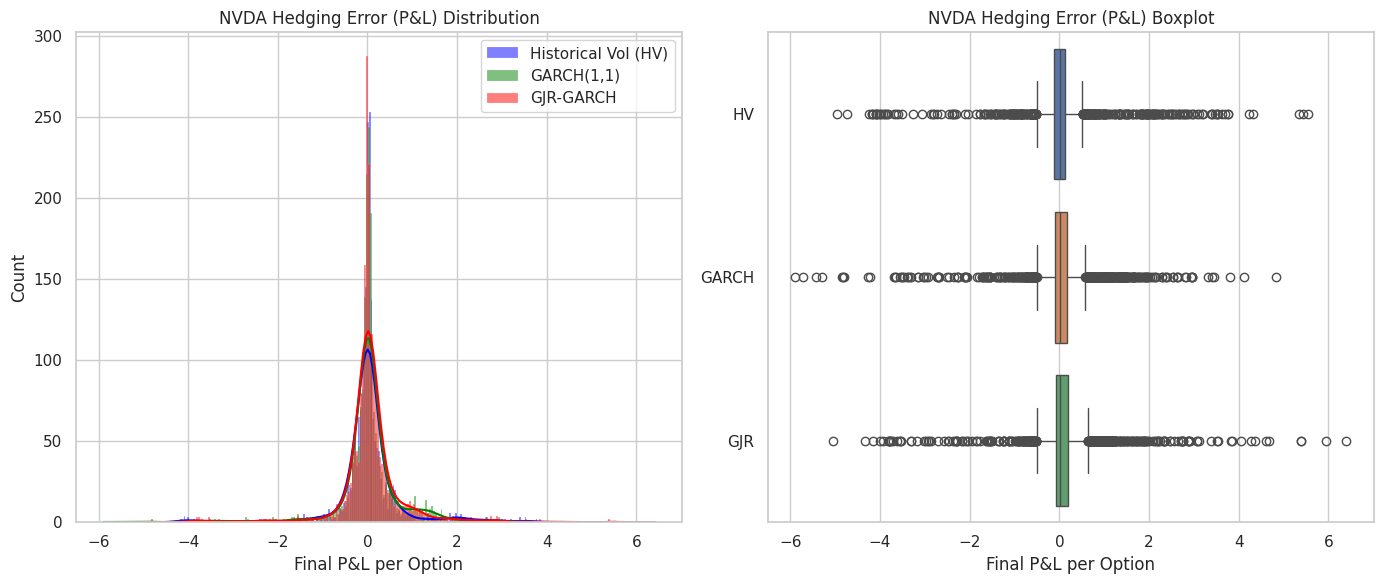


         Results for TSLA
       Mean Hedging P&L  Std Dev of P&L (Risk)  Variance of P&L
HV             0.470121               4.164410        17.342310
GARCH          0.799845               3.912594        15.308389
GJR            0.715360               3.941232        15.533311

TSLA GARCH(1,1) Variance Reduction vs HV: 11.73%
TSLA GJR-GARCH Variance Reduction vs HV: 10.43%


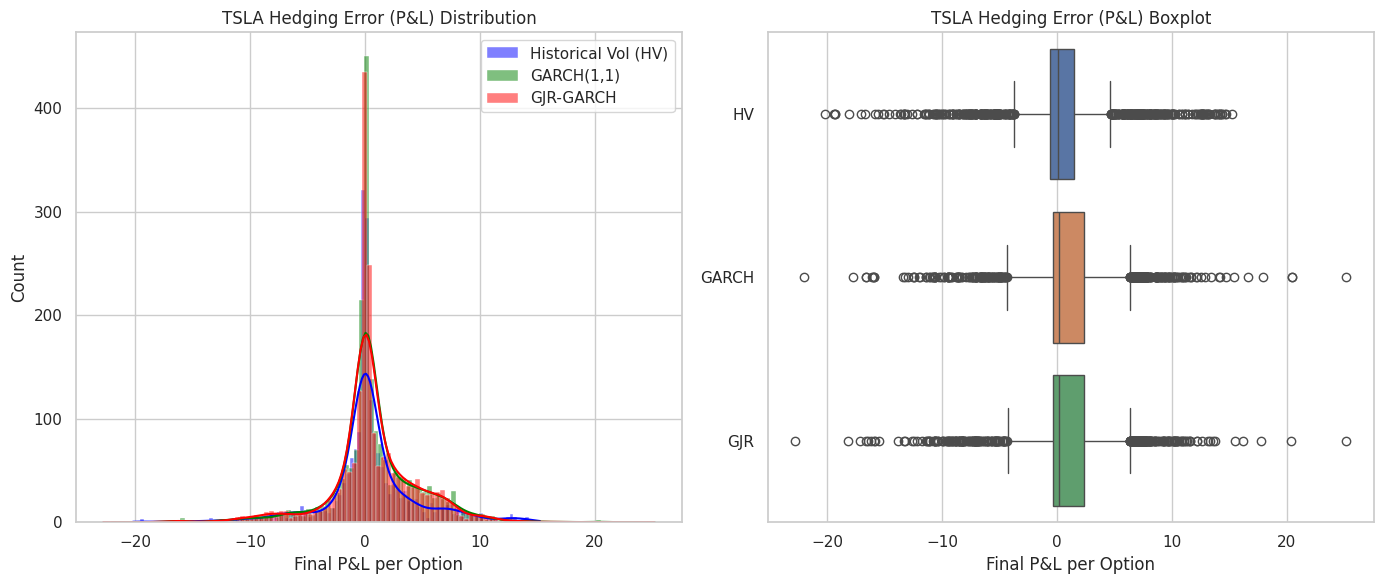

In [21]:
print("\n--- Final Hedging Performance Analysis (Rolling GARCH vs GJR) ---")

for ticker, results in all_results.items():
    print(f"\n========================================")
    print(f"         Results for {ticker}")
    print(f"========================================")

    stats = pd.DataFrame({
        'Mean Hedging P&L': results.mean(),
        'Std Dev of P&L (Risk)': results.std(),
        'Variance of P&L': results.var()
    })

    print(stats)

    # Calculate % reduction in variance
    hv_var = stats.loc['HV', 'Variance of P&L']
    garch_var = stats.loc['GARCH', 'Variance of P&L']
    gjr_var = stats.loc['GJR', 'Variance of P&L']

    garch_var_reduction = (hv_var - garch_var) / hv_var
    gjr_var_reduction = (hv_var - gjr_var) / hv_var

    print(f"\n{ticker} GARCH(1,1) Variance Reduction vs HV: {garch_var_reduction:.2%}")
    print(f"{ticker} GJR-GARCH Variance Reduction vs HV: {gjr_var_reduction:.2%}")

    # --- Plotting ---
    plt.figure(figsize=(14, 6))

    # Plot 1: Histogram of P&L
    plt.subplot(1, 2, 1)
    sns.histplot(results['HV'], color='blue', label='Historical Vol (HV)', kde=True, alpha=0.5)
    sns.histplot(results['GARCH'], color='green', label='GARCH(1,1)', kde=True, alpha=0.5)
    sns.histplot(results['GJR'], color='red', label='GJR-GARCH', kde=True, alpha=0.5)
    plt.title(f'{ticker} Hedging Error (P&L) Distribution')
    plt.xlabel('Final P&L per Option')
    plt.legend()

    # Plot 2: Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=results, orient='h')
    plt.title(f'{ticker} Hedging Error (P&L) Boxplot')
    plt.xlabel('Final P&L per Option')

    plt.tight_layout()
    plt.show()

#### Cell 7: Comparing Model parameters (γ)



In [22]:

print("--- Parameter Comparison for GJR-GARCH Models ---")
print("This will show WHY the models behave differently for each stock.\n")

# Use the full backtest period for a robust parameter fit
full_backtest_data = returns.loc[BACKTEST_START_DATE:]

for ticker in TICKERS:
    print(f"\n========================================")
    print(f"     GJR-GARCH(1,1,1) Summary for {ticker}")
    print(f"========================================")

    # Fit GJR-GARCH (p=1, o=1, q=1)
    model_gjr = arch_model(full_backtest_data[ticker], vol='Garch', p=1, o=1, q=1)

    # Fit the model
    # We use 'last_obs=' to get the most recent parameter set,
    # which is good practice.
    model_fit = model_gjr.fit(last_obs=full_backtest_data[ticker].index[-2], disp='off')

    # Print the summary
    print(model_fit.summary())
    print("\nKey Parameter to check:")
    print(f"  gamma[1] (The 'gamma' or leverage effect): {model_fit.params['gamma[1]']:.4f}")

--- Parameter Comparison for GJR-GARCH Models ---
This will show WHY the models behave differently for each stock.


     GJR-GARCH(1,1,1) Summary for AAPL
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3833.41
Distribution:                  Normal   AIC:                           7676.82
Method:            Maximum Likelihood   BIC:                           7704.84
                                        No. Observations:                 2009
Date:                Fri, Nov 07 2025   Df Residuals:                     2008
Time:                        15:27:39   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    


Our data tells a crystal-clear, three-part story that proves: "The best volatility model is not universal; it depends entirely on the underlying asset's unique volatility structure."

We have found three distinct groups in our data.

1. The "Textbook Case" (GOOGL & MSFT)
For GOOGL and MSFT, our hypothesis was 100% correct. GJR-GARCH (the "smart" asymmetric model) was the undisputed champion, reducing hedging risk by 20% and 18%, respectively.

Why? (The Parameters):

GOOGL γ: 0.0477 (P>|t| = 0.000)

MSFT γ: 0.0989 (P>|t| = 0.008)

 Conclusion: These stocks have a moderate, statistically significant leverage effect. The GJR-GARCH model correctly identified this "bad news" effect, created a superior forecast, and produced a more stable hedge. This is the ideal outcome.

2. The "Whipsaw Case" (AAPL & NVDA)
For AAPL and NVDA, the "smart" GJR-GARCH model failed, performing worse than the simpler GARCH(1,1). For AAPL, it was the worst model of all.

Why? (The Parameters):

AAPL γ: 0.1447 (P>|t| = 0.000)

NVDA γ: 0.1417 (P>|t| = 0.022)

Conclusion: This confirms our "whipsaw" hypothesis. The leverage effect (γ) for these stocks is extreme—roughly 1.5x to 3x larger than for MSFT and GOOGL. This "hyper-reactive" volatility, when fed into the naive Black-Scholes delta formula, caused the hedge to over-correct constantly. The model was too smart for the simple hedging framework, leading to costly "whipsaw" trades that increased risk.

3. The "Overfitting Case" (TSLA)
For TSLA, GJR-GARCH also failed, performing worse than the simple GARCH(1,1). But the reason is completely different.

Why? (The Parameters):

TSLA γ: -0.0046 (P>|t| = 0.706)

Conclusion: The P>|t| of 0.706 means the gamma parameter is not statistically different from zero. This means TSLA's volatility does not have a leverage effect.

The GJR-GARCH model failed here not because of "whipsaw" but because of over-parameterization. We used a complex, asymmetric model to describe an asset that isn't asymmetric.

Thus the simpler GARCH(1,1) model was a "truer" fit for TSLA's volatility, producing a cleaner forecast, and therefore resulted in a better, more stable hedge.

Thus to conclude, a successful hedging strategy requires not just a 'sophisticated' model, but one that is correctly specified for the unique volatility structure of the asset.